# Project 2 Question 0  
Luke Sturgeon  
Stat 517  
10/29/18  

### Loading Data and Dependencies

In [134]:
import seaborn as sb
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import ARDRegression
from sklearn.ensemble import BaggingRegressor

In [115]:
salary = pd.read_csv("http://www.webpages.uidaho.edu/~stevel/Datasets/salary_uk.csv")
salary= salary.drop(['SalaryRaw','SourceName','LocationRaw','Id'],axis=1)
salary.head()

,Title,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,25000
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,30000
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,30000
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,27500
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000


### Exploratory Data Analysis

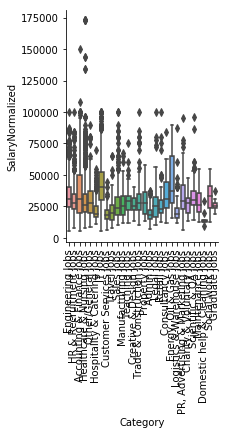

In [116]:
h = sb.factorplot("Category","SalaryNormalized", data=salary, kind="box")
h.set_xticklabels(rotation=90)

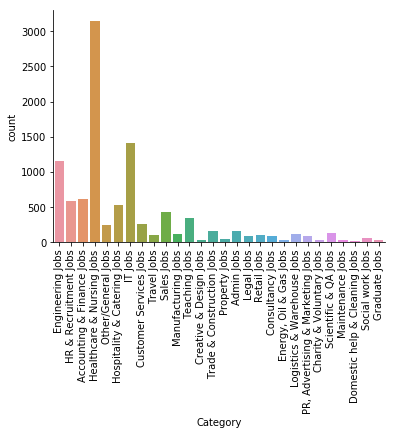

In [117]:
g = sb.factorplot("Category", data=salary, aspect=1.5, kind = "count")
g.set_xticklabels(rotation=90)

### Vectorizing the Terms in the Dataset

For this analysis, I took all of the columns that had words in them instead of numbers and vectorized them. This gave me a large and sparse data set of all the words and whether or not that observation had that word or not.

In [118]:
salary_vect = salary[['Title','FullDescription','Category','LocationNormalized','ContractTime','ContractType','Company']]
salary_vect.head()

,Title,FullDescription,Category,LocationNormalized,ContractTime,ContractType,Company
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Engineering Jobs,Dorking,permanent,NaN,Gregory Martin International
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Engineering Jobs,Glasgow,permanent,NaN,Gregory Martin International
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Engineering Jobs,Hampshire,permanent,NaN,Gregory Martin International
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Engineering Jobs,Surrey,permanent,NaN,Gregory Martin International
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Engineering Jobs,Surrey,permanent,NaN,Gregory Martin International


In [119]:
salary_vect.shape

(10000, 7)

In [120]:
vec = TfidfVectorizer(stop_words='english', max_features = 5000)
X_vec = vec.fit_transform(salary_vect['Title'].values.astype('str'))
Title_tfidf = pd.DataFrame(X_vec.todense(),columns=vec.get_feature_names())
Title_tfidf.shape

(10000, 3802)

In [121]:
Y_vec = vec.fit_transform(salary_vect['FullDescription'].values.astype('str'))
FullDescription_tfidf = pd.DataFrame(Y_vec.todense(),columns=vec.get_feature_names())
FullDescription_tfidf.shape

(10000, 5000)

In [122]:
Z_vec = vec.fit_transform(salary_vect['Category'].values.astype('str'))
Category_tfidf = pd.DataFrame(Z_vec.toarray(),columns=vec.get_feature_names())
Category_tfidf.shape

(10000, 45)

In [123]:
Location_vec = vec.fit_transform(salary_vect['LocationNormalized'].values.astype('str'))
Location_tfidf = pd.DataFrame(Location_vec.toarray(),columns=vec.get_feature_names())
Location_tfidf.shape

(10000, 935)

In [124]:
ContractTime_vec = vec.fit_transform(salary_vect['ContractTime'].values.astype('str'))
ContractTime_tfidf = pd.DataFrame(ContractTime_vec.toarray(),columns=vec.get_feature_names())
ContractTime_tfidf.shape

(10000, 3)

In [125]:
ContractType_vec = vec.fit_transform(salary_vect['ContractType'].values.astype('str'))
ContractType_tfidf = pd.DataFrame(ContractType_vec.toarray(),columns=vec.get_feature_names())
ContractType_tfidf.shape

(10000, 3)

In [126]:
Company_vec = vec.fit_transform(salary_vect['Company'].values.astype('str'))
Company_tfidf = pd.DataFrame(Company_vec.toarray(),columns=vec.get_feature_names())
Company_tfidf.shape

(10000, 1313)

In [127]:
smaller = pd.concat([FullDescription_tfidf,Title_tfidf,Category_tfidf,Location_tfidf,ContractTime_tfidf,ContractType_tfidf,Company_tfidf],axis=1)
smaller.shape

(10000, 11101)

This is the vectorized dataset. Of all the vectorized columns, "FullDescription" was the only one that was limited to few than the total number of words found in that column. It was limited to 5000 words. Anything more than that, my computer couldn't handl the size of the dataset. All of these vectorized columns were then put together back with the salary column so that it could be processed.

In [137]:
smaller_final = pd.concat([smaller,salary],axis=1)
smaller_final = smaller_final.drop(['Title','FullDescription','LocationNormalized','ContractType','ContractTime','Company','Category'],axis=1)
smaller_final.head()

,00,000,00am,00pm,10,100,10am,10pm,11,12,...,xperian,xpress,yacht,ymca,yorkshire,yourrecruit,zebra,zenith,zest,SalaryNormalized
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27500
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25000


### Splitting Data into Testing/Training Datasets

In [138]:
X=smaller_final.drop(['SalaryNormalized'],axis=1)
Y=smaller_final.SalaryNormalized

In [139]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1,test_size=0.1)
X_train.shape

(9000, 11101)

In [140]:
X_test.shape

(1000, 11101)

### Analysis

#### Bagging

In [145]:
bg = BaggingRegressor().fit(X_train,Y_train)
print("Training set score: {:.2f}".format(bg.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(bg.score(X_test, Y_test)))

Training set score: 0.93
Test set score: 0.61


In [146]:
bg10 = BaggingRegressor(n_estimators = 10).fit(X_train,Y_train)
print("Training set score: {:.2f}".format(bg10.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(bg10.score(X_test, Y_test)))

Training set score: 0.93
Test set score: 0.61


#### K Nearest Neighbor

In [151]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train,Y_train)
print("Training set score: {:.2f}".format(bg.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(bg.score(X_test, Y_test)))

Training set score: 0.93
Test set score: 0.61


In [152]:
kknn = KNeighborsRegressor(n_neighbors=50)
knn.fit(X_train,Y_train)
print("Training set score: {:.2f}".format(bg.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(bg.score(X_test, Y_test)))

Training set score: 0.93
Test set score: 0.61


In [153]:
kknn = KNeighborsRegressor(n_neighbors=100)
knn.fit(X_train,Y_train)
print("Training set score: {:.2f}".format(bg.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(bg.score(X_test, Y_test)))

Training set score: 0.93
Test set score: 0.61


#### Lasso

In [155]:
lasso = Lasso(alpha=0.001, max_iter=500).fit(X_train,Y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, Y_test)))

C:\Users\Luke\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training set score: 1.00
Test set score: -1.10


In [156]:
lasso01 = Lasso(alpha=0.01, max_iter=500).fit(X_train,Y_train)
print("Training set score: {:.2f}".format(lasso01.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(lasso01.score(X_test, Y_test)))

C:\Users\Luke\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training set score: 1.00
Test set score: -0.18


In [159]:
lasso1 = Lasso(alpha=0.1, max_iter=500).fit(X_train,Y_train)
print("Training set score: {:.2f}".format(lasso1.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(lasso1.score(X_test, Y_test)))

C:\Users\Luke\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training set score: 0.98
Test set score: 0.49


In [160]:
lasso9 = Lasso(alpha=0.9, max_iter=500).fit(X_train,Y_train)
print("Training set score: {:.2f}".format(lasso9.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(lasso9.score(X_test, Y_test)))

Training set score: 0.87
Test set score: 0.66


#### Ridge Regression

Other "solver" methods were attempted, but none could be completed with my computer's limitations.

In [161]:
ridge = Ridge().fit(X_train,Y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, Y_test)))

Training set score: 0.90
Test set score: 0.64


In [162]:
ridge1 = Ridge(alpha=1).fit(X_train,Y_train)
print("Training set score: {:.2f}".format(ridge1.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(ridge1.score(X_test, Y_test)))

Training set score: 0.90
Test set score: 0.64


In [163]:
ridge1 = Ridge(alpha=10).fit(X_train,Y_train)
print("Training set score: {:.2f}".format(ridge1.score(X_train, Y_train)))
print("Test set score: {:.2f}".format(ridge1.score(X_test, Y_test)))

Training set score: 0.73
Test set score: 0.60
